# 6 복습

# 혼동행렬 만드는 식 함수로

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1score = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정학도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, f1score: {3:.4f}'.format(accuracy, precision, recall, f1score))

# 타이타닉 예제 적용

## 전처리

In [8]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df_titanic = pd.read_csv('./datasets/titanic_train.csv')
df_titanic = df_titanic.loc[:,['Survived', 'Sex', 'Age', 'Pclass']]
X = df_titanic.loc[:,['Sex', 'Age', 'Pclass']]
y = df_titanic['Survived']
X['Age'].fillna(method='ffill', inplace=True) # 결측값을 바로 위 값과 동일하게

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(X['Sex'])
X['Sex'] = labels

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X[['Age']])
age_scaled = scaler.transform(X[['Age']])
X['Age'] = age_scaled

## confusion matrix 구하기

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[101  17]
 [ 12  49]]
정학도: 0.8380, 정밀도: 0.7424, 재현율: 0.8033, f1score: 0.7717


## 1과 0 분류 확률 중 큰 것으로 분류

In [11]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.42558527 0.57441473]
 [0.88833758 0.11166242]
 [0.88651722 0.11348278]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.42558527 0.57441473 1.        ]
 [0.88833758 0.11166242 0.        ]
 [0.88651722 0.11348278 0.        ]]


## 임계값에 따른 분류 - 0.5인 경우

In [12]:
from sklearn.preprocessing import Binarizer

custom_threshold = 0.5

pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[101  17]
 [ 12  49]]
정학도: 0.8380, 정밀도: 0.7424, 재현율: 0.8033, f1score: 0.7717


## 임계값에 따른 분류 - 0.4인 경우

In [14]:
from sklearn.preprocessing import Binarizer

custom_threshold = 0.4

pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[94 24]
 [10 51]]
정학도: 0.8101, 정밀도: 0.6800, 재현율: 0.8361, f1score: 0.7500


## threshold 함수 만들어 돌리기

In [15]:
from sklearn.preprocessing import Binarizer

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.4
오차행렬
[[94 24]
 [10 51]]
정학도: 0.8101, 정밀도: 0.6800, 재현율: 0.8361, f1score: 0.7500
임계값: 0.45
오차행렬
[[97 21]
 [11 50]]
정학도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, f1score: 0.7576
임계값: 0.5
오차행렬
[[101  17]
 [ 12  49]]
정학도: 0.8380, 정밀도: 0.7424, 재현율: 0.8033, f1score: 0.7717
임계값: 0.55
오차행렬
[[107  11]
 [ 17  44]]
정학도: 0.8436, 정밀도: 0.8000, 재현율: 0.7213, f1score: 0.7586
임계값: 0.6
오차행렬
[[111   7]
 [ 21  40]]
정학도: 0.8436, 정밀도: 0.8511, 재현율: 0.6557, f1score: 0.7407


## precision_recall_curve()로 정밀도-재현율 값 추출

In [16]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

print('반환된 분류 결정 임곗값 배열의 shape', thresholds.shape)
print('반환된 precisions 배열의 shape', precisions.shape)
print('반환된 recalls 배열의 shape', recalls.shape)

print("\nthresholds 5 samples:", thresholds[:5]) 
print("precisions 5 samples:", precisions[:5])
print("recalls 5 samples:", recalls[:5])

반환된 분류 결정 임곗값 배열의 shape (124,)
반환된 precisions 배열의 shape (125,)
반환된 recalls 배열의 shape (125,)

thresholds 5 samples: [0.06556004 0.07136752 0.0776467  0.07896181 0.08303016]
precisions 5 samples: [0.34078212 0.34269663 0.34659091 0.35057471 0.35465116]
recalls 5 samples: [1. 1. 1. 1. 1.]


# precision_recall_curve() 시각화

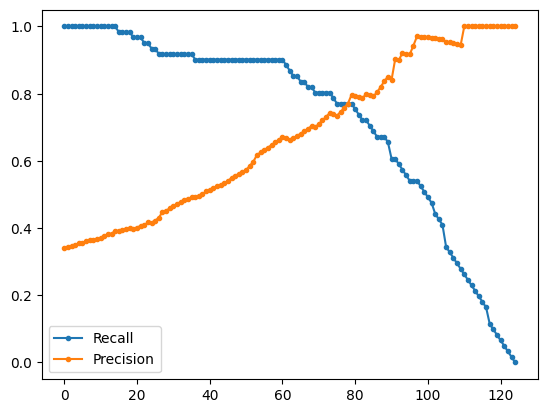

In [17]:
import matplotlib.pyplot as plt

plt.plot(recalls, marker='.', label='Recall')
plt.plot(precisions, marker='.', label = 'Precision')

plt.legend()
plt.show()

# ROC 곡선

In [18]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index],2))

print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51 56 61 66]
샘플 index로 추출한 임곗값: [0.95 0.81 0.65 0.6  0.55 0.47 0.4  0.27 0.18 0.13 0.12 0.11 0.1  0.08]
샘플 임계값별 FPR:  [0.    0.008 0.025 0.059 0.102 0.178 0.212 0.314 0.466 0.542 0.678 0.754
 0.839 0.941]
샘플 임계값별 TPR:  [0.016 0.344 0.541 0.656 0.721 0.803 0.852 0.902 0.902 0.918 0.934 0.967
 1.    1.   ]


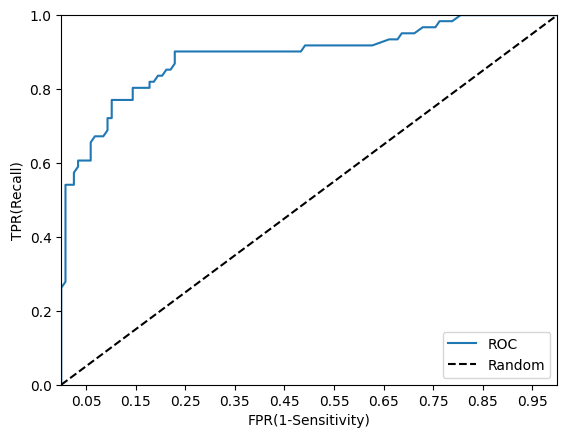

In [20]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, pred_proba_class1)

# AUC 스코어

In [21]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8900


# 8 복습 - DecisionTree

## iris 데이터 DecisionTree 학습

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [24]:
dt_clf = DecisionTreeClassifier(random_state=156, max_depth=3)
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=156)

In [26]:
from sklearn.metrics import accuracy_score

pred = dt_clf.predict(X_test)

print(f'정확도는: {accuracy_score(y_test, pred)}')

정확도는: 0.9333333333333333


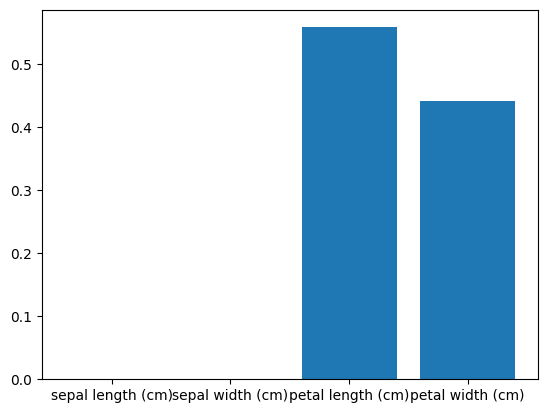

In [28]:
import matplotlib.pyplot as plt

plt.bar(iris_data.feature_names, dt_clf.feature_importances_)
plt.show()

In [29]:
from sklearn.tree import export_graphviz
export_graphviz(dt_clf, out_file='tree.dot', class_names=iris_data.target_names, feature_names=iris_data.feature_names)

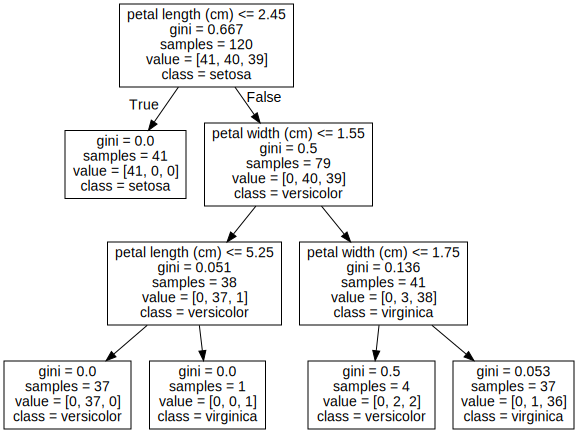

In [30]:
import graphviz
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## 분류 가상 데이터 만들기 

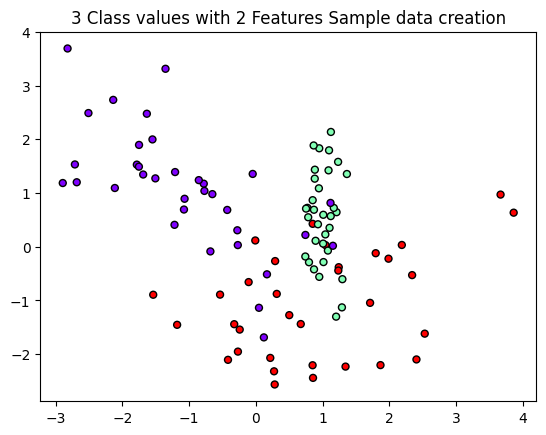

In [32]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('3 Class values with 2 Features Sample data creation')

x_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                          n_classes=3, n_clusters_per_class=1, random_state=0)

plt.scatter(x_features[:,0], x_features[:,1], marker='o', c=y_labels, s=25, cmap='rainbow', edgecolor='k')

## Decision Boundary를 시각화 하는 함수

In [38]:
import numpy as np

def visualize_boundary(model, X, y):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], c=y, s=25, cmap='rainbow', edgecolor='k')
    ax.axis('tight')
    ax.axis('off')
    xlim_start, xlim_end = ax.get_xlim()
    ylim_start, ylim_end = ax.get_ylim()
    
    model.fit(X,y)
    
    xx, yy = np.meshgrid(np.linspace(xlim_start, xlim_end, num=200), np.linspace(ylim_start, ylim_end, num=200))
    z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx,yy, z, alpha=0.3,
                          levels=np.arange(n_classes+1)-0.5,
                          cmap='rainbow', clim=(y.min(), y.max()),zorder=1)

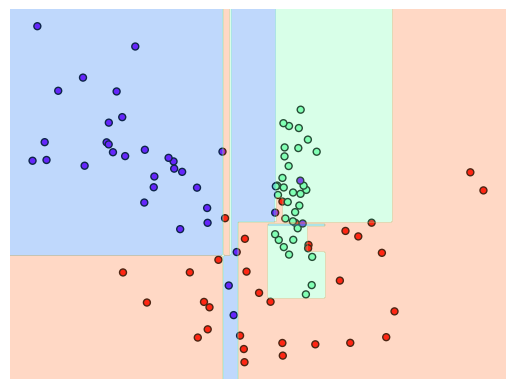

In [39]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier().fit(x_features, y_labels)
visualize_boundary(dt_clf, x_features, y_labels)

# 9 복습 - 앙상블

In [40]:
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

In [43]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier(random_state=0)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf), ('DC', dt_clf), ('RF', rf_clf)], voting='soft')
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

classifiers = [vo_clf, dt_clf, lr_clf, knn_clf, rf_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9474
VotingClassifier 정확도: 0.9474
DecisionTreeClassifier 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386
RandomForestClassifier 정확도: 0.9561
